## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_10-13-04-23.csv', firstRow=282, lastRow=288)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_100423_S283-288.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=82s and ended at t=496s; mass=43.5706g
This equals a volume of 43.658m; expected was 44.034mL; error is 0.855%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


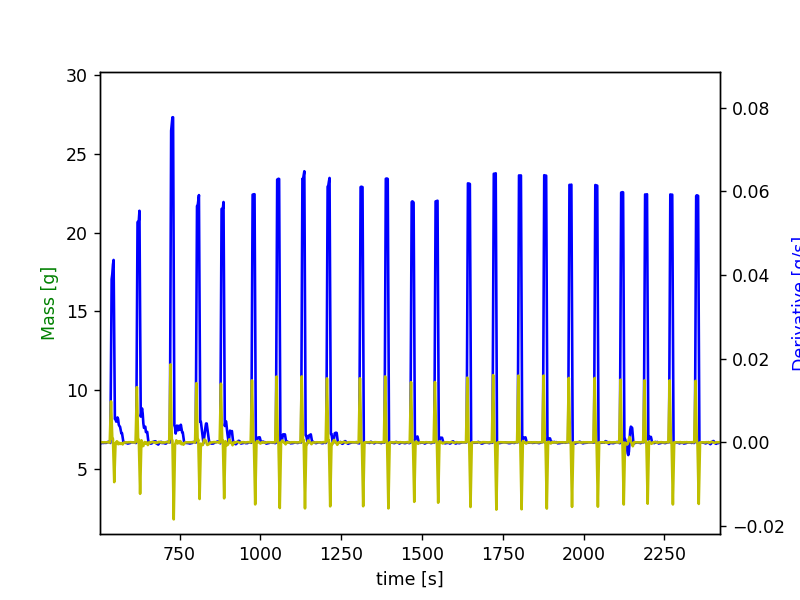

Addition of 0.524g Plantacare 818 detected from 534s to 580s - expected volume = 0.585mL and actual volume = 0.477mL (resulting error is 18.507%)
Addition of 0.646g Plantacare 818 detected from 614s to 658s - expected volume = 0.585mL and actual volume = 0.588mL (resulting error is 0.513%)
Addition of 0.86g Plantacare 2000 detected from 718s to 768s - expected volume = 0.935mL and actual volume = 0.781mL (resulting error is 16.472%)
Addition of 0.658g Plantacare 2000 detected from 798s to 846s - expected volume = 0.551mL and actual volume = 0.598mL (resulting error is 8.604%)
Addition of 0.634g Plantacare 2000 detected from 874s to 920s - expected volume = 0.551mL and actual volume = 0.577mL (resulting error is 4.773%)
Addition of 0.603g Dehyton PK 45 detected from 970s to 1004s - expected volume = 0.591mL and actual volume = 0.573mL (resulting error is 2.977%)
Addition of 0.648g Dehyton PK 45 detected from 1046s to 1084s - expected volume = 0.591mL and actual volume = 0.617mL (resulti

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

In [12]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=2, mergeSens=10, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>

Addition of 0.126g Luviquat Excellence detected from 2462s to 2482s - expected volume = 0.137mL and actual volume = 0.113mL (resulting error is 17.81%)
Addition of 0.177g Luviquat Excellence detected from 2570s to 2604s - expected volume = 0.166mL and actual volume = 0.16mL (resulting error is 3.872%)
Addition of 0.127g Luviquat Excellence detected from 2674s to 2712s - expected volume = 0.105mL and actual volume = 0.113mL (resulting error is 8.44%)
Addition of 0.11g Luviquat Excellence detected from 2780s to 2830s - expected volume = 0.091mL and actual volume = 0.098mL (resulting error is 7.598%)
Addition of 0.166g Luviquat Excellence detected from 2886s to 2934s - expected volume = 0.152mL and actual volume = 0.148mL (resulting error is 3.07%)
Addition of 0.122g Luviquat Excellence detected from 2994s to 3024s - expected volume = 0.113mL and actual volume = 0.11mL (resulting error is 3.075%)


## Analyse Thickeners

In [ ]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_100423_S277-S282.csv', index=False)
actualMassFractions